<a href="https://colab.research.google.com/github/alawrence30/Machine-Learning/blob/main/Assignment_3_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 03 - Ontology Plus Context and Modeling

Take the ontology that you developed in week 6 and consider how your ten chosen documents for this quarter's class corpus map to that ontology.

Protégé is a tool that takes inputs for a human-created Ontology and creates a visualization. 

Use Python algorithms to generate Knowledge Graphs from your documents.

TensorFlow Bidirectional RNN Model

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 11 22:45:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)

from typing import List, Callable, Dict, Tuple, Set

In [ ]:
## Code from Irina 
!python3 -m spacy download en
!python3 -m spacy download en_core_web_sm
!python3 -m spacy download en_core_web_lg
import spacy.cli
spacy.cli.download("en_core_web_lg")

     |████████████████████████████████| 12.0 MB 9.9 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 12.0 MB 13.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 827.9 MB 1.3 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=c5a84de57eb2e77bf641182b8f0ec116f9e03e42d73540b914011a7aeb66f20c
  Stored in directory: /tmp/pip-ephem-wheel-cache-f_18v8l4/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
✔ Download and in

<div class="alert alert-block alert-danger">
<b>Required Installation: en_core_web_lg</b><br>"python -m spacy download en_core_web_lg"<br><br>English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer<br>
    <b>https://spacy.io/models/en#en_core_web_lg </b>
</div>

In [ ]:
nlp = spacy.load('en_core_web_lg')

### Mount Google Drive to Colab Environment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### NLTK Downloads

In [ ]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [ ]:
import pkg_resources
pkg_resources.require("gensim<=3.8.3");

In [ ]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.6.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [ ]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)
    
def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:    
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc): 
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

## Knowledge Context Graph Functions

In [ ]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    
def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')
    
    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)
    
    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')
    
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []
    
    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()
            
        output.append(rows)
        sources = set(rows.target).union(set(rows.source))
        
    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))
        
    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (18, 18), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=5)
        
    plt.show()
    
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

## Entity Extraction Functions

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

## Visualization Utility Functions

In [ ]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Loading the Class Corpus

In [ ]:
##CORPUS_PATH = './data/MSDS453_QA_TEST.csv'
##corpus_df = get_corpus_df(CORPUS_PATH)

#read in class corpus csv into python
work_dir = "/content/gdrive/My Drive/MSDS 453/Assignment 3/"
corpus_df = get_corpus_df(work_dir + 'ClassCorpus_v2.csv')

## Exploratory Data Analysis

In [ ]:
## Before tokenizing sentences
corpus_df.head(3).T

Doc_ID,191,192,193
DSI_Title,JLU_Doc1_JamesBondCasinoRoyale,JLU_Doc2_JamesBondCasinoRoyale,JLU_Doc3_JamesBondCasinoRoyale
Student Name,JLU,JLU,JLU
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,"James Bond, Casino Royale","James Bond, Casino Royale","James Bond, Casino Royale"
Text,Is this where we are at? Is this the state of ...,"Give or take the odd Octopussy, I suppose, lik...",The James Bond films have been with us for mor...
Descriptor,"Action_James Bond, Casino Royale_N_191","Action_James Bond, Casino Royale_N_192","Action_James Bond, Casino Royale_N_193"
Doc_ID,191,192,193


In [ ]:
# Tokenize sentences
corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)
corpus_df.head(3).T

Doc_ID,191,192,193
DSI_Title,JLU_Doc1_JamesBondCasinoRoyale,JLU_Doc2_JamesBondCasinoRoyale,JLU_Doc3_JamesBondCasinoRoyale
Student Name,JLU,JLU,JLU
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,"James Bond, Casino Royale","James Bond, Casino Royale","James Bond, Casino Royale"
Text,Is this where we are at? Is this the state of ...,"Give or take the odd Octopussy, I suppose, lik...",The James Bond films have been with us for mor...
Descriptor,"Action_James Bond, Casino Royale_N_191","Action_James Bond, Casino Royale_N_192","Action_James Bond, Casino Royale_N_193"
Doc_ID,191,192,193
raw_sentences,"[Is this where we are at?, Is this the state o...","[Give or take the odd Octopussy, I suppose, li...",[The James Bond films have been with us for mo...


In [ ]:
# Tokenize words
default_stopwords = set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
191    [pron, state, nation, bring, cold, war, let, p...
192    [odd, octopussy, pron, suppose, like, pron, pr...
193    [james, bond, film, pron, year, bad, pron, bar...
194    [introduction, new, james, bond, bring, skepti...
195    [box, office, remain, strong, worldwide, arden...
Name: lemmas, dtype: object

In [ ]:
# Reassemble lemmas
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

In [ ]:
## lemmas_joined = commas removed
corpus_df['lemmas_joined'].head()

Doc_ID
191    pron state nation bring cold war let pron dump...
192    odd octopussy pron suppose like pron pron pret...
193    james bond film pron year bad pron barometer p...
194    introduction new james bond bring skepticism m...
195    box office remain strong worldwide ardent fan ...
Name: lemmas_joined, dtype: object

In [ ]:
corpus_df.head(3).T

Doc_ID,191,192,193
DSI_Title,JLU_Doc1_JamesBondCasinoRoyale,JLU_Doc2_JamesBondCasinoRoyale,JLU_Doc3_JamesBondCasinoRoyale
Student Name,JLU,JLU,JLU
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,"James Bond, Casino Royale","James Bond, Casino Royale","James Bond, Casino Royale"
Text,Is this where we are at? Is this the state of ...,"Give or take the odd Octopussy, I suppose, lik...",The James Bond films have been with us for mor...
Descriptor,"Action_James Bond, Casino Royale_N_191","Action_James Bond, Casino Royale_N_192","Action_James Bond, Casino Royale_N_193"
Doc_ID,191,192,193
raw_sentences,"[Is this where we are at?, Is this the state o...","[Give or take the odd Octopussy, I suppose, li...",[The James Bond films have been with us for mo...
lemmas,"[pron, state, nation, bring, cold, war, let, p...","[odd, octopussy, pron, suppose, like, pron, pr...","[james, bond, film, pron, year, bad, pron, bar..."


## Vocabulary Data Wrangling

In [ ]:
# Generate a set of additional words to remove by DF
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

Vocabulary size: 12453
Vocabulary size: 3010


Text(0, 0.5, 'Number of Terms')

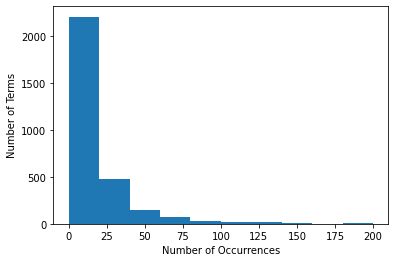

In [ ]:
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Terms')

^ A lot of words are used frequently, some of the low frequency words may have high predicability power, some of the high frequency words may have low predictablility power

In [ ]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

Doc_ID
191    [state, nation, bring, cold, war, let, dump, b...
192    [odd, suppose, pretty, forget, memory, process...
193    [james, bond, year, bad, popular, mood, layer,...
194    [introduction, new, james, bond, bring, major,...
195    [box, office, remain, strong, fan, james, bond...
Name: lemmas, dtype: object

In [ ]:
corpus_df.head(2).T

Doc_ID,191,192
DSI_Title,JLU_Doc1_JamesBondCasinoRoyale,JLU_Doc2_JamesBondCasinoRoyale
Student Name,JLU,JLU
Genre of Movie,Action,Action
Review Type (pos or neg),Negative,Negative
Movie Title,"James Bond, Casino Royale","James Bond, Casino Royale"
Text,Is this where we are at? Is this the state of ...,"Give or take the odd Octopussy, I suppose, lik..."
Descriptor,"Action_James Bond, Casino Royale_N_191","Action_James Bond, Casino Royale_N_192"
Doc_ID,191,192
raw_sentences,"[Is this where we are at?, Is this the state o...","[Give or take the odd Octopussy, I suppose, li..."
lemmas,"[state, nation, bring, cold, war, let, dump, b...","[odd, suppose, pretty, forget, memory, process..."


In [ ]:
# Get lemmatized and filtered sentences (removes the additional words)
corpus_df['sentences_lemmatized'] = corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])
corpus_df.head(2).T

Doc_ID,191,192
DSI_Title,JLU_Doc1_JamesBondCasinoRoyale,JLU_Doc2_JamesBondCasinoRoyale
Student Name,JLU,JLU
Genre of Movie,Action,Action
Review Type (pos or neg),Negative,Negative
Movie Title,"James Bond, Casino Royale","James Bond, Casino Royale"
Text,Is this where we are at? Is this the state of ...,"Give or take the odd Octopussy, I suppose, lik..."
Descriptor,"Action_James Bond, Casino Royale_N_191","Action_James Bond, Casino Royale_N_192"
Doc_ID,191,192
raw_sentences,"[Is this where we are at?, Is this the state o...","[Give or take the odd Octopussy, I suppose, li..."
lemmas,"[state, nation, bring, cold, war, let, dump, b...","[odd, suppose, pretty, forget, memory, process..."


## Review Documents By Movie Title

In [ ]:
print(corpus_df['Movie Title'].unique())

['James Bond, Casino Royale' 'Mission Impossible Fallout'
 'Pirates of the Caribbean: The Curse of the Black Pearl' 'Speed Racer'
 'Cruella' 'Encanto' 'Frozen II' 'Red Notice' 'Spider Man 3'
 'The Grand Budapest Hotel' 'Hereditary' 'Lamb' 'The Conjuring 3'
 'The Ring' 'Us' 'Arrival' 'Guardians of the Galaxy' 'Interstellar'
 'The Martian' 'The Matrix Resurrections']


In [ ]:
## Create copy
movie_df = corpus_df[corpus_df['Movie Title'] == 'Interstellar'].copy()
movie_df.head(3).T

Doc_ID,36,37,38
DSI_Title,AKL_Doc6_Interstellar,AKL_Doc7_Interstellar,AKL_Doc8_Interstellar
Student Name,AKL,AKL,AKL
Genre of Movie,Sci-Fi,Sci-Fi,Sci-Fi
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Interstellar,Interstellar,Interstellar
Text,"Yes, I recognize the egregious tardiness of th...","Remember Gravity. Remember the simplicity, raw...","""Interstellar"" is the biggest and boldest movi..."
Descriptor,Sci-Fi_Interstellar_N_36,Sci-Fi_Interstellar_N_37,Sci-Fi_Interstellar_N_38
Doc_ID,36,37,38
raw_sentences,"[Yes, I recognize the egregious tardiness of t...","[Remember Gravity., Remember the simplicity, r...","[""Interstellar"" is the biggest and boldest mov..."
lemmas,"[yes, recognize, review, interstellar, week, s...","[remember, gravity, remember, simplicity, raw,...","[interstellar, big, bold, year, nearly, hour, ..."


In [ ]:
## Find top terms by frequency 
from collections import Counter
Counter(" ".join(movie_df['lemmas_joined']).split()).most_common(50)

[('interstellar', 60),
 ('nolan', 51),
 ('cooper', 51),
 ('space', 44),
 ('time', 43),
 ('earth', 35),
 ('mcconaughey', 29),
 ('planet', 25),
 ('daughter', 25),
 ('leave', 23),
 ('find', 20),
 ('nasa', 19),
 ('world', 19),
 ('year', 19),
 ('good', 17),
 ('father', 17),
 ('brand', 17),
 ('inception', 16),
 ('mission', 16),
 ('dust', 16),
 ('work', 15),
 ('wormhole', 15),
 ('hathaway', 15),
 ('human', 15),
 ('love', 14),
 ('future', 14),
 ('far', 14),
 ('new', 14),
 ('pilot', 14),
 ('look', 13),
 ('long', 13),
 ('feel', 13),
 ('murph', 13),
 ('christopher', 12),
 ('place', 12),
 ('come', 12),
 ('head', 12),
 ('caine', 12),
 ('set', 12),
 ('play', 12),
 ('point', 12),
 ('science', 12),
 ('want', 11),
 ('near', 11),
 ('way', 11),
 ('story', 11),
 ('old', 11),
 ('saturn', 10),
 ('director', 10),
 ('matthew', 10)]

## Knowledge Graph Extraction

In [ ]:
corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]
example_sentence = nlp(corpus_text_sentences[1])
corpus_text_sentences[1]

'“Interstellar” has been out for over a week now.'

In [ ]:
## Check subject and object (should only be one of each)
for tok in example_sentence:
  print(tok.text, "...", tok.dep_)

“ ... punct
Interstellar ... nsubj
” ... punct
has ... aux
been ... ROOT
out ... advmod
for ... prep
over ... quantmod
a ... nummod
week ... pobj
now ... advmod
. ... punct


^subject = Interstellar, object = week

In [ ]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]
entity_pairs

100%|██████████| 446/446 [00:05<00:00, 78.45it/s]


[['I', 'egregious  review'],
 ['Interstellar', 'a  week'],
 ['three day I', 'school moms'],
 ['Being', 'agenda'],
 ['I', 'brevity'],
 ['Christopher film', ''],
 ['It', 'tricky  Interstellar'],
 ['latest', 'previous  films'],
 ['I', 'Memento'],
 ['much  you', ''],
 ['exactly  I', ''],
 ['watching  it', 'watching  opportunity'],
 ['often  you', '70 mm IMAX'],
 ['It', ''],
 ['only  which', 'only  contradictions'],
 ['certainly  he', 'fervent  film'],
 ['beautiful Hoyte Van work', 'Spike Jonze'],
 ['', ''],
 ['cinematographer', ''],
 ['Individual  moments', 'various spaceship brown'],
 ['other  shots', 'conspicuously space models'],
 ['which', 'scientific  complexity'],
 ['they', 'often  dozing'],
 ['Nolan', 'brother'],
 ['It', 'simplistic tech love'],
 ['little  result', 'clockwork filmmaking'],
 ['insistent Hans Zimmer which', 'signature Inception'],
 ['Interstellar', 'muddled sound issues'],
 ['you', 'necessarily  it'],
 ['which', 'draggy'],
 ['where  farming', 'primary  purpose'],
 [''

### Create DataFrame (Source, Target, Edge)

In [ ]:
relations = [get_relation(x) for x in corpus_text_sentences]   
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

pd.Series(relations).value_counts()[:10]

is          57
’s          27
are         10
be           5
takes        4
need         4
becomes      3
believes     3
has          3
look         3
dtype: int64

^ source = word, target = word, edge = line

### Knowledge Graph Preprocessing (Lowercase, Remove Empty Spaces)

Graph 1 raw_sentences: lowercase, remove empty spaces

In [ ]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [ ]:
print(len(corpus_text_sentences))
kg_df.head(5)

446


,source,target,edge
0,i,egregious review,recognize
1,interstellar,a week,been
2,three day i,school moms,started
3,being,agenda,was
4,i,brevity,’s


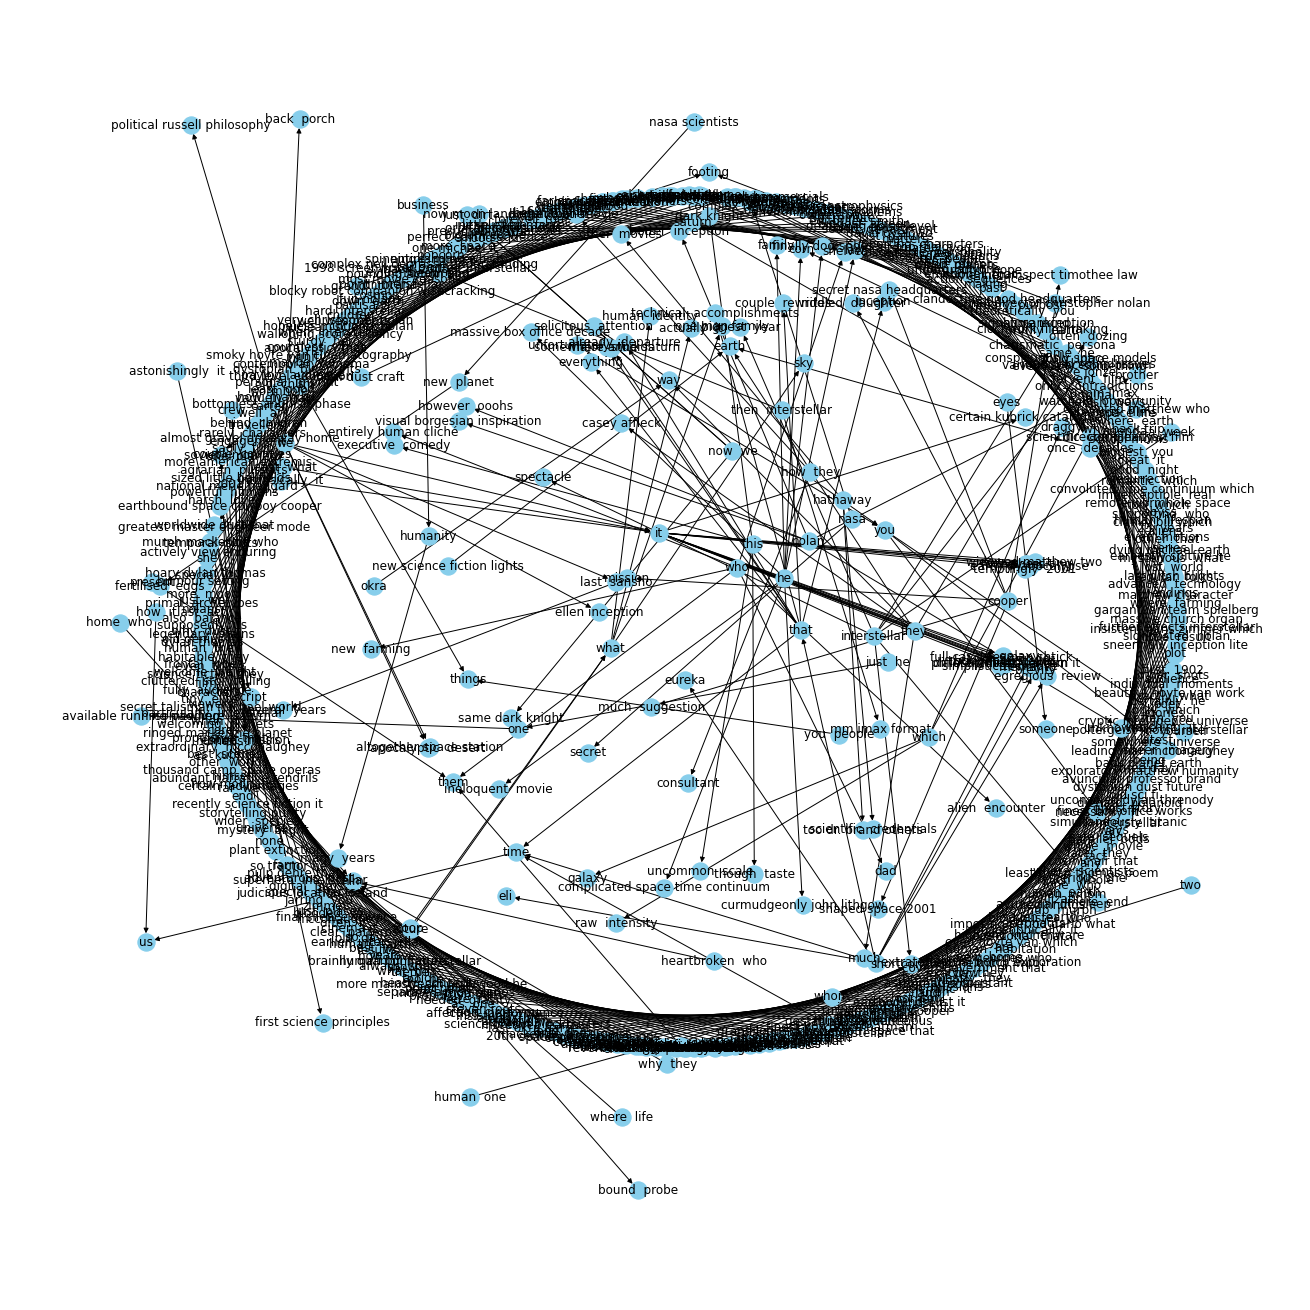

In [ ]:
plot_graph(kg_df, use_circular=False)

Graph 2 sentences_lemmatized

In [ ]:
movie_df['lemmas_sentences'] = corpus_df.lemmas_joined.apply(get_sentences)
corpus_text_sentences2 = [y for x in movie_df.lemmas_sentences for y in x]
example_sentence2 = nlp(corpus_text_sentences2[1])
corpus_text_sentences2[1]

'interstellar week start stop write good solid half dozen time include day lady bunch school mom agenda time'

In [ ]:
movie_df.head(3).T

Doc_ID,36,37,38
DSI_Title,AKL_Doc6_Interstellar,AKL_Doc7_Interstellar,AKL_Doc8_Interstellar
Student Name,AKL,AKL,AKL
Genre of Movie,Sci-Fi,Sci-Fi,Sci-Fi
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Interstellar,Interstellar,Interstellar
Text,"Yes, I recognize the egregious tardiness of th...","Remember Gravity. Remember the simplicity, raw...","""Interstellar"" is the biggest and boldest movi..."
Descriptor,Sci-Fi_Interstellar_N_36,Sci-Fi_Interstellar_N_37,Sci-Fi_Interstellar_N_38
Doc_ID,36,37,38
raw_sentences,"[Yes, I recognize the egregious tardiness of t...","[Remember Gravity., Remember the simplicity, r...","[""Interstellar"" is the biggest and boldest mov..."
lemmas,"[yes, recognize, review, interstellar, week, s...","[remember, gravity, remember, simplicity, raw,...","[interstellar, big, bold, year, nearly, hour, ..."


In [ ]:
entity_pairs2 = [get_entities(x) for x in tqdm(corpus_text_sentences2)]

100%|██████████| 370/370 [00:03<00:00, 100.63it/s]


In [ ]:
relations2 = [get_relation(x) for x in corpus_text_sentences2]
#extract subject and object
source2 = [i[0] for i in entity_pairs2]
target2 = [i[1] for i in entity_pairs2]
kg_df2 = kg_df_2 = pd.DataFrame({'source': source2, 'target': target2, 'edge': relations2})

pd.Series(relations2).value_counts()[:10]

leave      11
find        7
begin       6
think       6
come        6
look        6
let         5
explain     5
play        5
remain      5
dtype: int64

In [ ]:
kg_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  370 non-null    object
 1   target  370 non-null    object
 2   edge    370 non-null    object
dtypes: object(3)
memory usage: 8.8+ KB


In [ ]:
# Move everything to lower case
kg_df2.source = kg_df2.source.str.lower()
kg_df2.target = kg_df2.target.str.lower()
kg_df2.edge = kg_df2.edge.str.lower()

# Filter out empties
kg_df2 = kg_df2[kg_df2.source != '']
kg_df2 = kg_df2[kg_df2.target != '']
kg_df2 = kg_df2[kg_df2.edge != ''].copy()

In [ ]:
kg_df2.head(5).T

,2,6,8,9,11
source,dig,singular watch opportunity,vast station look interstellar,scientific inspire script nolan,precision filmmaking
target,tricky christopher thing,undoubtedly project,strong place scenario ambition,high jonathan tech,little result
edge,try,chance,appreciate,write,appreciate


In [ ]:
len(corpus_text_sentences2)

370

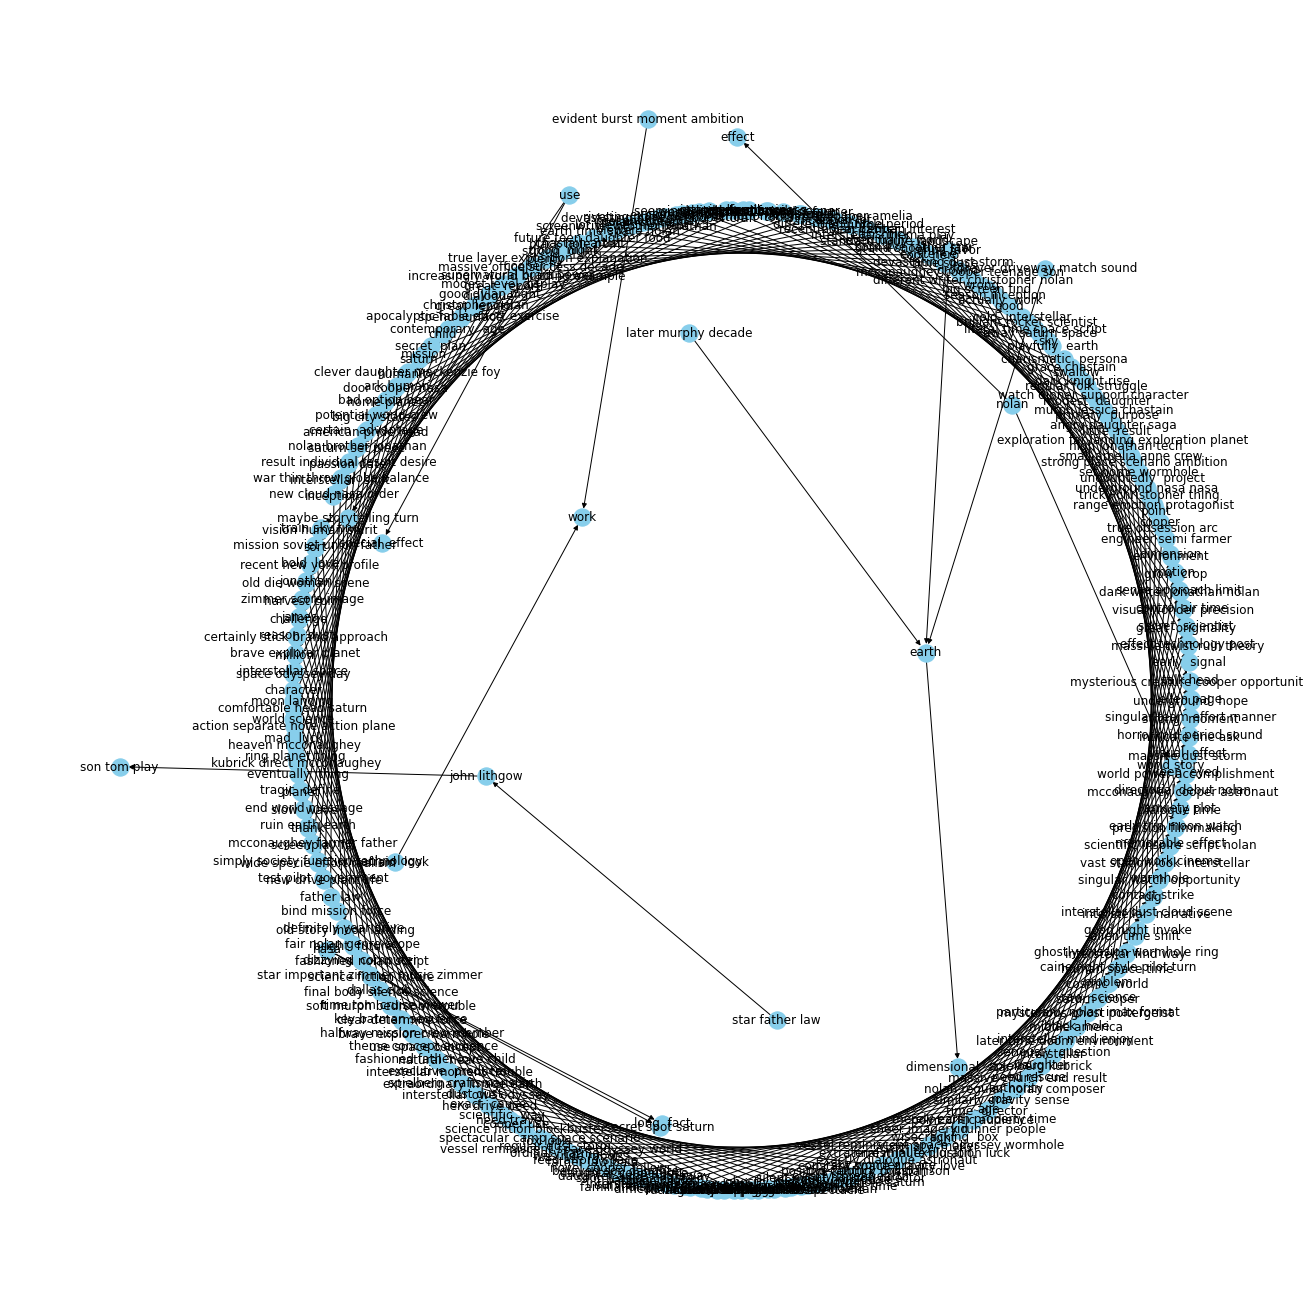

In [ ]:
plot_graph(kg_df2, use_circular=False)

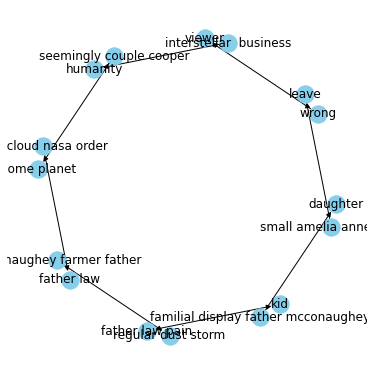

In [ ]:
# Graph 2, edge = 'leave'
plot_graph(kg_df2.loc[kg_df2['edge'] == 'leave'], figsize=[5,5], use_circular=False)

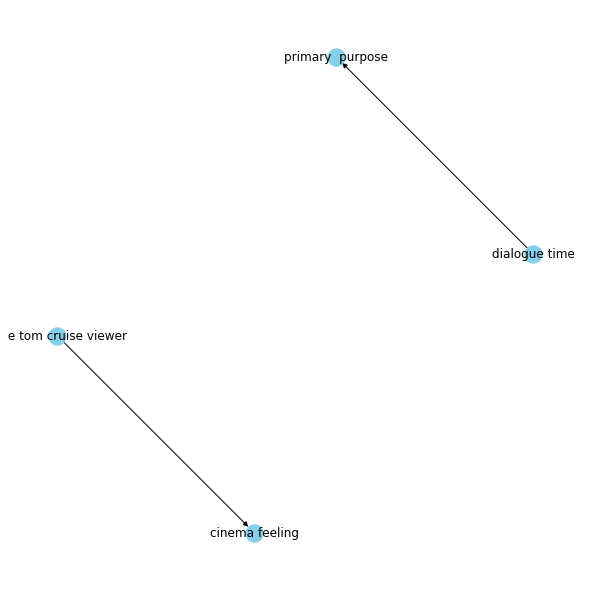

In [ ]:
# Graph 2, edge = 'find'
plot_graph(kg_df2.loc[kg_df2['edge'] == 'find'], figsize=[8,8], use_circular=False)

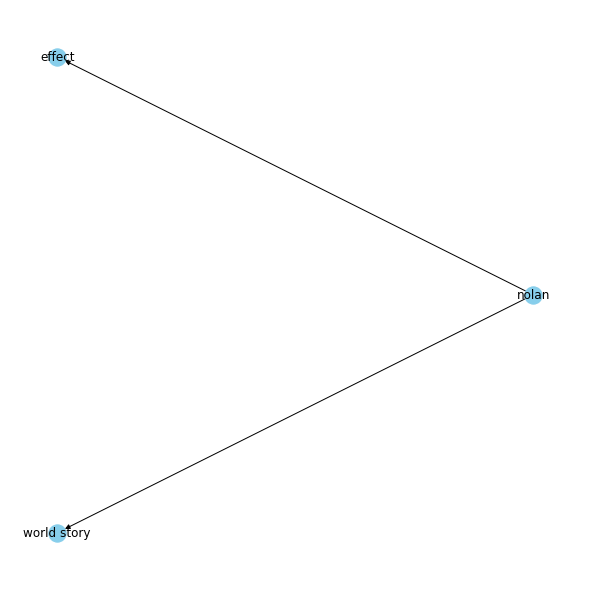

In [ ]:
# Graph 2, source = 'nolan'
plot_graph(kg_df2.loc[kg_df2['source'] == 'nolan'], figsize=[8,8], use_circular=False)

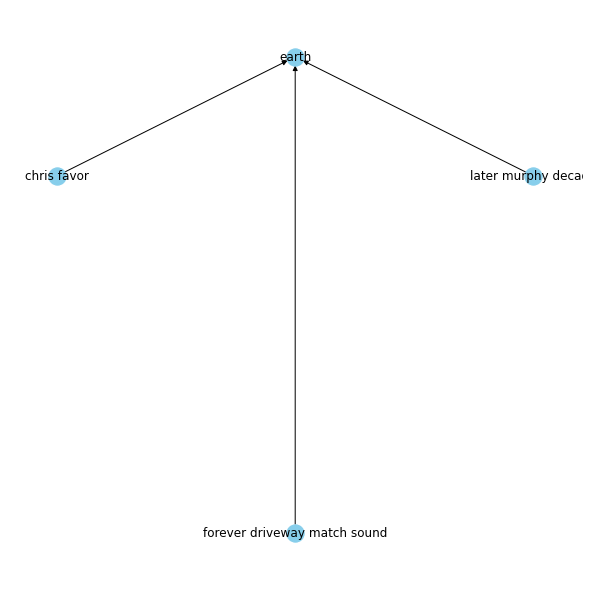

In [ ]:
# Graph 2, target = 'time'
plot_graph(kg_df2.loc[kg_df2['target'] == 'earth'], figsize=[8,8], use_circular=False)

## Recurrent Neural Network (RNN) Model Development

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/BidirectionalRNN.png?raw=true">

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

In [ ]:
datafull=corpus_df.copy() 
datafull.reset_index(drop=True, inplace=True)
datafull.head().T

,0,1,2,3,4
DSI_Title,JLU_Doc1_JamesBondCasinoRoyale,JLU_Doc2_JamesBondCasinoRoyale,JLU_Doc3_JamesBondCasinoRoyale,JLU_Doc4_JamesBondCasinoRoyale,JLU_Doc5_JamesBondCasinoRoyale
Student Name,JLU,JLU,JLU,JLU,JLU
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,"James Bond, Casino Royale","James Bond, Casino Royale","James Bond, Casino Royale","James Bond, Casino Royale","James Bond, Casino Royale"
Text,Is this where we are at? Is this the state of ...,"Give or take the odd Octopussy, I suppose, lik...",The James Bond films have been with us for mor...,The introduction of a new James Bond always br...,Although box office has remained strong worldw...
Descriptor,"Action_James Bond, Casino Royale_N_191","Action_James Bond, Casino Royale_N_192","Action_James Bond, Casino Royale_N_193","Action_James Bond, Casino Royale_N_194","Action_James Bond, Casino Royale_N_195"
Doc_ID,191,192,193,194,195
raw_sentences,"[Is this where we are at?, Is this the state o...","[Give or take the odd Octopussy, I suppose, li...",[The James Bond films have been with us for mo...,[The introduction of a new James Bond always b...,[Although box office has remained strong world...
lemmas,"[state, nation, bring, cold, war, let, dump, b...","[odd, suppose, pretty, forget, memory, process...","[james, bond, year, bad, popular, mood, layer,...","[introduction, new, james, bond, bring, major,...","[box, office, remain, strong, fan, james, bond..."


In [ ]:
datafull['Text'] = datafull['Text'].apply(lambda x :clean_doc(x))

## Pre process data

No document vectorization (TFIDF) is needed for these models.
We are reading the words.

X = examples, y = labels

Text = sequence (examples)

Genre of Movies = label (what is trying to be predicted)

In [ ]:
data = datafull[['Text','Genre of Movie']].copy()

Convert genre into a code (four genres > assigned numbers 1-3)

In [ ]:
data['Genre of Movie'] = data['Genre of Movie'].astype("category")
data['Genre of Movie code'] = data['Genre of Movie'].cat.codes
data['Genre of Movie code'].tail().T

195    3
196    3
197    3
198    3
199    3
Name: Genre of Movie code, dtype: int8

Train (80%), Test (20%), Split

Targest = Labels

In [ ]:
features, targets = data['Text'], data['Genre of Movie code']
 
train_features, test_features, train_targets, test_targets = train_test_split( features, targets , test_size=0.20, random_state=42, shuffle = True,
        stratify=targets)
data[["Genre of Movie","Genre of Movie code"]].value_counts()

Genre of Movie  Genre of Movie code
Comedy          1                      60
Horror          2                      50
Sci-Fi          3                      50
Action          0                      40
dtype: int64

## Create Datasets for Model Development

Create validation set

In [ ]:
trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Genre of Movie code']])
trainds.shape, valds.shape, testds.shape

((160, 2), (20, 2), (20, 2))

## Convert DataFrame to TensorFlow DataSet

Convert from Pandas to TenserFlow data

Text > strings

Genres > integers

creates x's and y's

In [ ]:
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Genre of Movie code'].values, tf.int64),
  ) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Genre of Movie code'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
) 
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Genre of Movie code'].values, tf.int64),
)

## Create DataSets (X=Preprocessed Text, Y=Encoded Categories)

Compiling to create datasets

In [ ]:
train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

## Create Data Pipelines (Batching, Shuffling, and Optimizing)

pipleline = how data is fed to models

autotune pulls examples, autotunes examples coming in

batch size = 3 (records at a time)

shuffle helps eliminates memorization of data

In [ ]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds = val_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Text                 200 non-null    object  
 1   Genre of Movie       200 non-null    category
 2   Genre of Movie code  200 non-null    int8    
dtypes: category(1), int8(1), object(1)
memory usage: 2.3+ KB


## Create the Text Encoder

vectorizing (I believe)

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.

In [ ]:
##x_train = train_features.to_numpy()
##y_train = train_targets.to_numpy()
##x_test = test_features.to_numpy()
##y_test = test_targets.to_numpy()

In [ ]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

In [ ]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

5000

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', '’', 'the', 'film', 's', 'i', 'movie', 'one', 'it',
       'like', '“', '”', 'time', 'character', 'bond', 'but', 'story',
       'also', 'make'], dtype='<U18')

In [ ]:
vocab[-20:]

array(['vastness', 'vanished', 'vampire', 'valley', 'vain', 'vacationing',
       'utilizes', 'utilized', 'utilize', 'ursula', 'urging', 'urban',
       'uptight', 'upstaging', 'upsetting', 'upright', 'upping', 'upper',
       'upbeat', 'up'], dtype='<U18')

## Example of Encoded Words

0 = padding

1 = unknown word

In [ ]:
encoded_example = encoder('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([ 450,  244,    1,  794, 3023, 1918,  475,  475])

In [ ]:
len(encoder.get_vocabulary())

5000

In [ ]:
## 1 are unknown words (hopefully filler words)
encoder(data['Text'][0])

<tf.Tensor: shape=(372,), dtype=int64, numpy=
array([ 931,  931, 1384,  718,  327,   33,  779,  463,  286,    5,    1,
         15,    1,    1,  701,    5,   42, 4164, 1515,    5,    1,  936,
         15,    1,    1,    1,    1,    1,   35,   74,   15, 3344,    5,
        342, 1165, 1857,  315, 1791, 1086,  733,  515,  357,  338,  100,
          4, 2631,    1,  357,    1,  593, 2384,   10, 3483, 3939,    1,
       2670,  935,  174,    5,   15,    1, 2821,   74,  343,  116, 4212,
        199,  824, 2866,   79,    1, 1623,   15,   14,  276,  913, 1165,
       1500,  281, 4162,   27,    1,    1, 1985,  408,  223,    8, 4194,
         68,    4,   10,  307,  154,   36, 3549, 1263,  349,   52, 1003,
       3602,   15, 3081,  905,   72,  130,  606,  226,    1, 1208,  903,
        576,  780, 3551,  174,   10, 3551,    1, 4971, 2078, 4888,  105,
       1070,    1, 1547,    3,  515,   15,   20,  249, 1065,   36, 3553,
       4734, 4333,  189,    1,  255,   96,  609,   64, 1224, 4051,    6,
     

Python byte code

In [ ]:
for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b'With \xe2\x80\x9c Frozen II , \xe2\x80\x9d Disney done impossible : It \xe2\x80\x99 made terrific animated-musical sequel . Over past 25 year , studio released heap direct-to-video follow-up biggest hit , \xe2\x80\x9c Return Jafar \xe2\x80\x9d \xe2\x80\x9c The Lion King 1\xc2\xbd . \xe2\x80\x9d All forgettable best , forever banished darkest corner Disney+ . But curse lifted . The second \xe2\x80\x9c Frozen \xe2\x80\x9d even better first , dazzling animation mature tuneful score . Call \xe2\x80\x9c The Icicle Strikes Back . \xe2\x80\x9d Elsa sang , \xe2\x80\x9c I \xe2\x80\x99 never going back ! The past past ! \xe2\x80\x9d And \xe2\x80\x9c Frozen II \xe2\x80\x9d wisely followed path . Instead rehashing 2013 film , piling complication involving queen \xe2\x80\x99 magical ability freeze fingertip , start fresh new , out-of-the-icebox adventure . Our heroine sits throne Arendelle , despite high queen , Elsa ( Idina Menzel ) feel nagging void . She begin hearing siren song calli

## Build RNN Sequential Model 

<div class="alert alert-block alert-info">
    <b>Module: tf.keras.layers</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers
    </div>

Embedding layer = learning from the document (64 cells). Masking = if data coming in could change the weights of the model, it will pass it and let it go thorugh withough adjusting the weight


Bidirectional layers = read text from right to left and left to right at the same time. LSTM = Long short term memory layer (contains 64 cells). Dropout = 30% to keep from overfitting. Second LSTM layer (contains 32 cells to condense what we're learning). 

Important features should be identified.

Dense layer = fiinal layer for classification and prediction (64 nodes). Understand importance based upon activation values. Activation function = relu (helps decide what to pass on to the next layer, provides simple "if/else"). Second dense layer = for prediction number of classes = 4 (four genres). Activation function = softmax (range between 0 and 1... each percentage for each class (4) has to sum to 1. Class with highest % is what will be predecited/output as prediction)

In [ ]:
num_classes=4
model=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')  
])

Change around optimizers (other than Adam)

Loss function = how model is getting "less bad"

Metrics = what we're paying attention to (accuracy)

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
              ,metrics=['accuracy'])

Pass in trainign data (epcochs set to 200)

validation set, so it knows how to tune parameters

call backs (class htat has methods, saying if validation accuracy doesn't improve after 2 epochs (two run thrus) stop training) 

In [ ]:
%%time
history = model.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)])

Epoch 1/200
53/53 [==============================] - 37s 230ms/step - loss: 1.3824 - accuracy: 0.3019 - val_loss: 1.3323 - val_accuracy: 0.3333
Epoch 2/200
53/53 [==============================] - 5s 92ms/step - loss: 1.1250 - accuracy: 0.4277 - val_loss: 1.1637 - val_accuracy: 0.5556
Epoch 3/200
53/53 [==============================] - 5s 90ms/step - loss: 0.8247 - accuracy: 0.5912 - val_loss: 1.1938 - val_accuracy: 0.5556
Epoch 4/200
53/53 [==============================] - 5s 90ms/step - loss: 0.6129 - accuracy: 0.7610 - val_loss: 0.7219 - val_accuracy: 0.6667
Epoch 5/200
53/53 [==============================] - 5s 90ms/step - loss: 0.2379 - accuracy: 0.9497 - val_loss: 0.8546 - val_accuracy: 0.6667
Epoch 6/200
53/53 [==============================] - 5s 90ms/step - loss: 0.0412 - accuracy: 0.9937 - val_loss: 0.9302 - val_accuracy: 0.7778
Epoch 7/200
53/53 [==============================] - 5s 91ms/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 2.6042 - val_accuracy: 0.4444
Epoc

## Model Performance Test Accuracy

VALIDATION ACCURACY is ABOVE 

Test accuracy is below

Look at how to improve: hyper parameter tuning and preprocessing 

In [ ]:
test_loss, test_acc = model.evaluate(val_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 0s 32ms/step - loss: 1.7487 - accuracy: 0.5556
Test Loss: 1.7487294673919678
Test Accuracy: 0.5555555820465088


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
## Create dataframe
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
4,0.238,0.950,0.855,0.667
5,0.041,0.994,0.930,0.778
6,0.014,1.000,2.604,0.444
7,0.006,1.000,2.331,0.333
8,0.004,1.000,1.075,0.667


In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

Normal to have different between training and validation if metrics are in the same direction, that's good. If validation starts to stagnate, while training continues to improve, that's overfitting probably. If validation is going in a different/wrong direction it is overfitting.

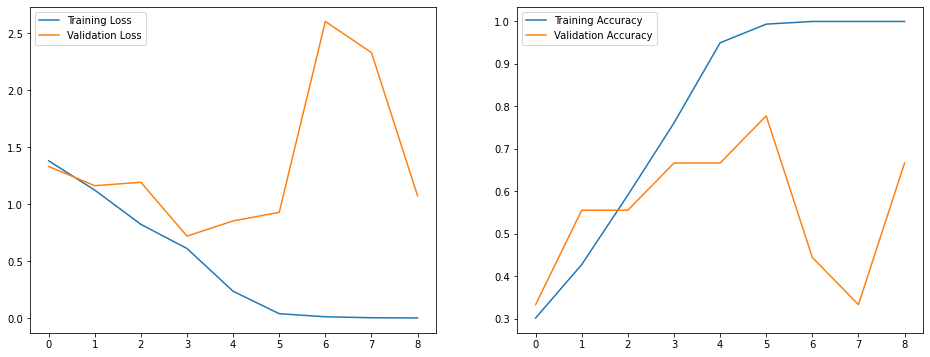

In [ ]:
plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion Matrix Post Model Performance Analysis

In [ ]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

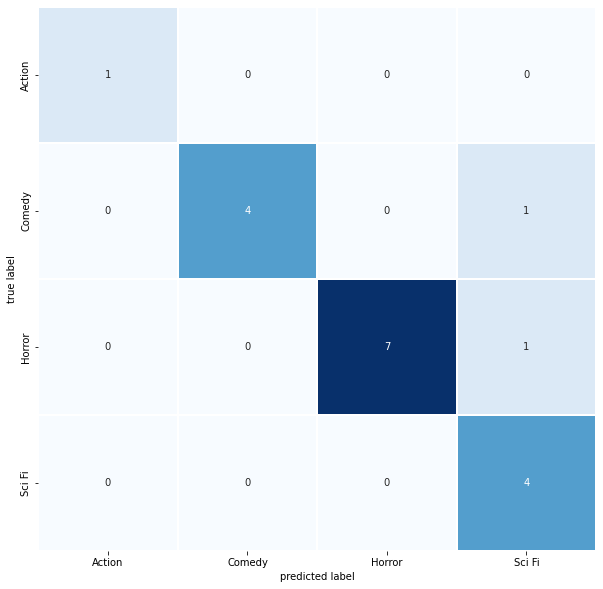

In [ ]:
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df2 = pd.DataFrame(preds2[0:15]
                  ,columns = CLASSES_LIST).T
df2.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Action,0.10%,0.01%,8.24%,0.04%,0.01%,0.66%,0.61%,0.31%,0.27%,0.02%,0.29%,0.60%,0.19%,0.01%,0.10%
Comedy,99.76%,0.01%,0.10%,0.02%,0.01%,0.00%,97.65%,0.00%,0.00%,0.02%,0.00%,0.00%,99.47%,0.01%,99.75%
Horror,0.00%,0.20%,48.14%,0.47%,0.21%,98.06%,0.03%,99.52%,99.54%,0.18%,99.49%,97.79%,0.00%,0.40%,0.00%
Sci Fi,0.13%,99.78%,43.52%,99.47%,99.76%,1.28%,1.72%,0.17%,0.19%,99.78%,0.22%,1.60%,0.33%,99.58%,0.15%


## RNN Model Architecture

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        